<a href="https://colab.research.google.com/github/timothyow/simple_math_agent/blob/main/Agent_math.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install langchain==0.3.14
!pip install langchain-openai==0.3.0
!pip install langchain-community==0.3.14
!pip install langgraph==0.2.64

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.9/326.9 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 59.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.3.42
    Uninstalling langsmith-0.3.42:
      Successfully uninstalled langsmith-0.3.42
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.25
    Uninstalling langchain-0.3.25:
      Successfully uninstalled langchain-0.3.25
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy

Approach:
1. Define Custom Functions:
○ Implement plus, subtract, multiply, and divide as custom tools.
2. Integrate LLM:
○ Use LLM to answer general questions.
3. Create LangGraph:
○ Set up a state graph with two nodes: one for the chatbot (LLM) and one for the
mathematical tools.
4. Conditional Edges:
○ Use conditional edges to call the mathematical tools when a math query is
detected.
5. Test Queries:
○ Test the system with both general queries and math-related queries

In [3]:
from getpass import getpass

OPENAI_KEY = getpass('Enter Open AI API Key: ')

Enter Open AI API Key: ··········


In [4]:
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY

In [5]:
from langchain_core.tools import tool
import json
import requests
from tqdm import tqdm
from datetime import datetime, timedelta


@tool
def plus(a,b) -> float:
    """additional of two numbers"""
    results = a + b
    return results

def subtract(a,b) -> float:
    """subtract two numbers"""
    results = a - b
    return results

def multiply(a,b) -> float:
    """multiplication of two numbers"""
    results = a * b
    return results

def divide(a,b) -> float:
    """division of two numbers"""
    try:
      if b == 0:
        raise ZeroDivisionError ("Cannot divide by zero")

      results = a / b
      return results

    except ZeroDivisionError as e:
      return str(e)



In [7]:
#try tool

from IPython.display import display, Markdown

response = divide(5,5)
display(response)

1.0

Build tool-use agent using LangGraph

In [8]:
AGENT_SYS_PROMPT = """Role: You are an AI math assistant tasked with providing general and math-related queries seamlessly.

Objective: Provide accurate answers to math related questions and answer general questions.

Capabilities: You are given a number of tools as functions. Use as many tools
as needed to ensure all information provided is timely, accurate, concise,
relevant, and responsive to the user's query.

Starting Flow:
Input validation: Determine if the input is asking about a specific math question (Flow 2). If not, check if they are asking for general questions (Flow 1). Otherwise, respond in a friendly, positive, professional tone
that you don't have information to answer.
For each of the flows related to valid questions use the following instructions:

Flow 1:
General questions, answer to your best ability based on your trained knowledge, if questions are out of your knowledge, answer politely that you do not know the answer.

Flow 2:
If the query is related to specific math question on addition, subtraction, multiplication or division, use the tools to answer the question.
Use multiple math tools if required to answer math questions.

Response Generation Flow:
Compose Response: Analyze the retrieved data carefully and provide an accurate answer to the user in a clear and concise format,
in a friendly professional tone, emphasizing the data retrieved.
When generating the final response in markdown,
if there are more than one decimal point, round the answer up to one decimal point e.g 5.561234 should become \5.6

Check carefully and only call the tools which are specifically named below.
Only use data obtained from these tools.
"""

In [9]:
import tiktoken
# just checking size of the system prompt so we do not cross 128K context window limit when trimming messages later
enc = tiktoken.encoding_for_model("gpt-4o")
tokens = enc.encode(AGENT_SYS_PROMPT)
print(f"Number of tokens: {len(tokens)}")

Number of tokens: 321


text### Key Steps:

1. **State Definition**:
   - The `State` class defines the structure of the conversation state, which holds the list of messages.

2. **Tools Setup**:
   - The `tools` list contains functions the agent can use to fetch data or perform actions (e.g., addition, subtraction).

3. **LLM Initialization**:
   - The `ChatOpenAI` instance is initialized with GPT-4o and bound to the tools, enabling the agent to use them when needed.

4. **Chatbot Node**:
   - The `chatbot` function processes user input, trims the conversation history to avoid exceeding token limits, and generates a response using the LLM.

5. **Tool Node**:
   - The `ToolNode` handles the execution of tools when the agent decides to use them (e.g., using addition or subtraction tool).

6. **Graph Construction**:
   - The graph is built by adding nodes (chatbot and tools) and edges, with conditional logic to decide when to use tools or end the conversation.

7. **Agent Compilation**:
   - The graph is compiled into a runnable agent (`simple_math_agent`), which can process user inputs and interact with tools as needed.

In [10]:
from typing import Annotated
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import HumanMessage, SystemMessage, RemoveMessage
from langchain_core.messages import trim_messages

In [11]:
# Define the state of the graph, which holds the conversation messages
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Initialize the graph builder with the defined state
graph_builder = StateGraph(State)

# List of tools the agent can use
tools = [
    plus,
    subtract,
    multiply,
    divide
]

# Initialize the LLM (GPT-4) and bind the tools to it
llm = ChatOpenAI(model="gpt-4o", temperature=0)
llm_with_tools = llm.bind_tools(tools)

# System message to guide the agent's behavior
SYS_MSG = SystemMessage(content=AGENT_SYS_PROMPT)

# Define the chatbot node, which processes user input and generates responses
def chatbot(state: State):
    # Trim messages to avoid exceeding token limits
    messages = trim_messages(
        state["messages"],
        max_tokens=127000,
        strategy="last", # keep last 127K tokens in messages
        token_counter=ChatOpenAI(model="gpt-4o"),
        include_system=True, # keep system message always
        allow_partial=True, # trim messages to partial content if needed

    )
    # Invoke the LLM with the system message and trimmed conversation history
    return {"messages": [llm_with_tools.invoke([SYS_MSG] + messages)]}

# Add the chatbot node to the graph
graph_builder.add_node("chatbot", chatbot)

# Add a node for executing tools (e.g., fetching data, searching the web)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# Add conditional edges: the chatbot decides whether to use tools or end the conversation
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    ['tools', END]
)

# After using a tool, return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")

# Set the chatbot as the entry point of the graph
graph_builder.set_entry_point("chatbot")

# Compile the graph into a runnable agent
simple_math_agent = graph_builder.compile()

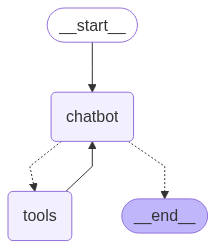

In [12]:
from IPython.display import display, Image

Image(simple_math_agent.get_graph().draw_mermaid_png())

**Test the agent**

In [13]:
from IPython.display import display, Markdown

response = llm.invoke('what is today date?')
display(response.content)

"I'm sorry, but I can't provide real-time information, including today's date. You might want to check your device or a calendar for the current date."

In [14]:
def call_agent(agent, prompt, user_config={"configurable": {"thread_id": "any"}}):
    events = agent.stream(
        {"messages": [{"role": "user", "content": prompt}]},
        user_config,
        stream_mode="values",
    )

    for event in events:
        event["messages"][-1].pretty_print()

    print()
    print('Final Response:\n')
    display(Markdown(event["messages"][-1].content))

In [15]:
query = 'How much is 5+5?'
call_agent(simple_math_agent, query)

================================ Human Message =================================

How much is 5+5?
================================== Ai Message ==================================
Tool Calls:
  plus (call_3aOaNoOsq53QqHdE2eNE3pBN)
 Call ID: call_3aOaNoOsq53QqHdE2eNE3pBN
  Args:
    a: 5
    b: 5
================================= Tool Message =================================
Name: plus

10
================================== Ai Message ==================================

The result of \(5 + 5\) is \(10\).

Final Response:



The result of \(5 + 5\) is \(10\).

In [16]:
query = 'How much is 6+5?'
call_agent(simple_math_agent, query)

================================ Human Message =================================

How much is 6+5?
================================== Ai Message ==================================
Tool Calls:
  plus (call_8qQTDwfbrL9o5EsjKiZlLwNH)
 Call ID: call_8qQTDwfbrL9o5EsjKiZlLwNH
  Args:
    a: 6
    b: 5
================================= Tool Message =================================
Name: plus

11
================================== Ai Message ==================================

The result of \(6 + 5\) is \(11\).

Final Response:



The result of \(6 + 5\) is \(11\).

In [17]:
query = 'How is the weather today?'
call_agent(simple_math_agent, query)

================================ Human Message =================================

How is the weather today?
================================== Ai Message ==================================

I'm sorry, but I don't have access to real-time data, including current weather conditions. You might want to check a reliable weather website or app for the most up-to-date information.

Final Response:



I'm sorry, but I don't have access to real-time data, including current weather conditions. You might want to check a reliable weather website or app for the most up-to-date information.

In [18]:
query = 'How much is an average bowl of noodles in Singapore'
call_agent(simple_math_agent, query)

================================ Human Message =================================

How much is an average bowl of noodles in Singapore
================================== Ai Message ==================================

The price of an average bowl of noodles in Singapore can vary depending on the type of noodles and the location. Generally, at a hawker center or food court, you can expect to pay around SGD 3 to SGD 6 for a basic bowl of noodles. In more upscale restaurants or specialty noodle shops, the price can range from SGD 10 to SGD 20 or more. Prices can fluctuate based on ingredients, portion size, and the establishment's location.

Final Response:



The price of an average bowl of noodles in Singapore can vary depending on the type of noodles and the location. Generally, at a hawker center or food court, you can expect to pay around SGD 3 to SGD 6 for a basic bowl of noodles. In more upscale restaurants or specialty noodle shops, the price can range from SGD 10 to SGD 20 or more. Prices can fluctuate based on ingredients, portion size, and the establishment's location.

In [19]:
query = 'How much is 5+5? and is this more expensive than an average bowl of noodles in Singapore'
call_agent(simple_math_agent, query)

================================ Human Message =================================

How much is 5+5? and is this more expensive than an average bowl of noodles in Singapore
================================== Ai Message ==================================
Tool Calls:
  plus (call_baRjP3lHP0l1y5ubEcXfzLRs)
 Call ID: call_baRjP3lHP0l1y5ubEcXfzLRs
  Args:
    a: 5
    b: 5
================================= Tool Message =================================
Name: plus

10
================================== Ai Message ==================================

The result of \(5 + 5\) is 10.

Regarding the cost of an average bowl of noodles in Singapore, it typically ranges from SGD 3 to SGD 6, depending on the type and location. Therefore, 10 is not a monetary value, but if you were comparing it to the cost in Singapore dollars, it would be more than the average cost of a bowl of noodles.

Final Response:



The result of \(5 + 5\) is 10.

Regarding the cost of an average bowl of noodles in Singapore, it typically ranges from SGD 3 to SGD 6, depending on the type and location. Therefore, 10 is not a monetary value, but if you were comparing it to the cost in Singapore dollars, it would be more than the average cost of a bowl of noodles.